In [1]:
!pip install transformers peft --quiet

import torch
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel, PeftConfig
from google.colab import drive

drive.mount('/content/drive')

peft_model_path = "/content/drive/MyDrive/xlm_roberta_finetuned_9L"
peft_config = PeftConfig.from_pretrained(peft_model_path)

base_model = AutoModelForSequenceClassification.from_pretrained(
    peft_config.base_model_name_or_path,
    output_hidden_states=True,
    num_labels=4
)

tokenizer = AutoTokenizer.from_pretrained(peft_config.base_model_name_or_path)
model = PeftModel.from_pretrained(base_model, peft_model_path)
model.eval()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.5 MB/s eta 0:00:00
Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): XLMRobertaForSequenceClassification(
      (roberta): XLMRobertaModel(
        (embeddings): XLMRobertaEmbeddings(
          (word_embeddings): Embedding(250002, 1024, padding_idx=1)
          (position_embeddings): Embedding(514, 1024, padding_idx=1)
          (token_type_embeddings): Embedding(1, 1024)
          (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): XLMRobertaEncoder(
          (layer): ModuleList(
            (0-23): 24 x XLMRobertaLayer(
              (attention): XLMRobertaAttention(
                (self): XLMRobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.2, inplace=False)
                    )
     

In [4]:
df = pd.read_csv("/content/x_fact_test_clean_9L.csv")

def compute_input_gradient(text):
    # در صورت نیاز اسم roberta رو به xlm_roberta تغییر بده
    roberta_model = model.base_model.roberta
    embedding_layer = roberta_model.embeddings.word_embeddings

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    raw_embeds = embedding_layer(input_ids)
    input_embeds = raw_embeds.clone().detach().requires_grad_(True)

    model.zero_grad()

    encoder_outputs = roberta_model(
        inputs_embeds=input_embeds,
        attention_mask=attention_mask,
        output_hidden_states=True,
        return_dict=True
    )

    last_hidden_state = encoder_outputs.hidden_states[-1]
    logits = model.base_model.classifier(last_hidden_state)
    pred = torch.argmax(logits, dim=-1)

    logits[0, pred[0]].backward()
    grad_norm = input_embeds.grad.norm(dim=2).mean(dim=1).item()
    return grad_norm


In [5]:
from collections import defaultdict

n_samples = 10
results = []  # لیست برای ساخت DataFrame

# زبان‌ها و برچسب‌ها
languages = df['source_language'].unique()
labels = df['label'].unique()

for lang in languages:
    for lbl in labels:
        subset = df[(df['source_language'] == lang) & (df['label'] == lbl)]

        if len(subset) == 0:
            continue  # هیچ نمونه ای با این زبان و برچسب نیست

        # انتخاب حداکثر 10 نمونه
        sample_df = subset.sample(min(n_samples, len(subset)), random_state=42)

        grads_list = []
        for _, row in sample_df.iterrows():
            text = row['claim']
            grad_value = compute_input_gradient(text)
            grads_list.append(grad_value)

        avg_grad = sum(grads_list) / len(grads_list)
        results.append({
            'language': lang,
            'label': lbl,
            'avg_gradient': avg_grad,
            'count_samples': len(sample_df)
        })

print(" Done computing gradients for each (language, label).")


 Done computing gradients for each (language, label).


In [6]:
df_results = pd.DataFrame(results)
df_results.sort_values(by=['language','label'], inplace=True)
df_results.reset_index(drop=True, inplace=True)

df_results


,language,label,avg_gradient,count_samples
0,de,false,1.178049,10
1,de,mostly false,0.308792,10
2,de,mostly true,0.229771,10
3,de,true,0.211691,8
4,es,false,0.221681,10
5,es,mostly false,1.501090,10
6,es,mostly true,0.209968,10
7,es,true,0.418408,10
8,fa,false,0.434016,10
9,fa,mostly false,0.161965,2


In [7]:
df_results.to_csv("/content/lang_label_gradients.csv", index=False)
print(" Saved to /content/lang_label_gradients.csv")


 Saved to /content/lang_label_gradients.csv


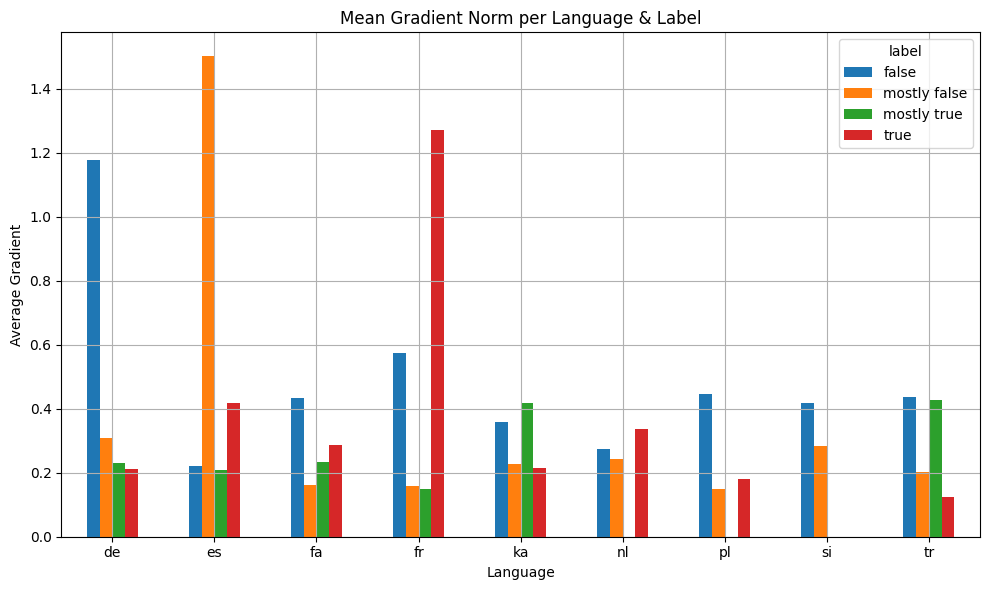

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# بارگذاری نتایج
df_results = pd.read_csv("/content/lang_label_gradients.csv")

# رسم نمودار بارپلات چندگروهی
fig, ax = plt.subplots(figsize=(10, 6))

# مرتب‌سازی برای زیبایی
df_results.sort_values(by=["language", "label"], inplace=True)

# pivot کردن داده برای راحتی با matplotlib
pivot_df = df_results.pivot(index="language", columns="label", values="avg_gradient")

pivot_df.plot(kind="bar", ax=ax, rot=0)

plt.title("Mean Gradient Norm per Language & Label")
plt.xlabel("Language")
plt.ylabel("Average Gradient")
plt.grid(True)
plt.tight_layout()
plt.show()


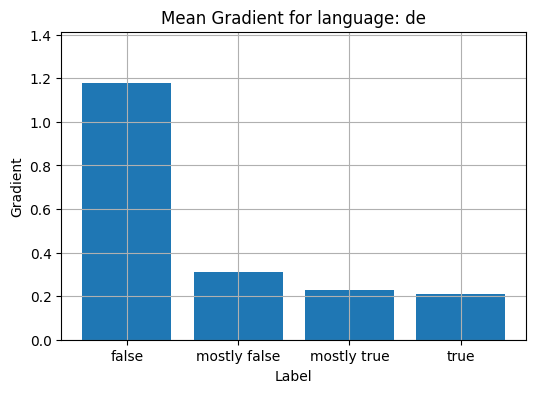

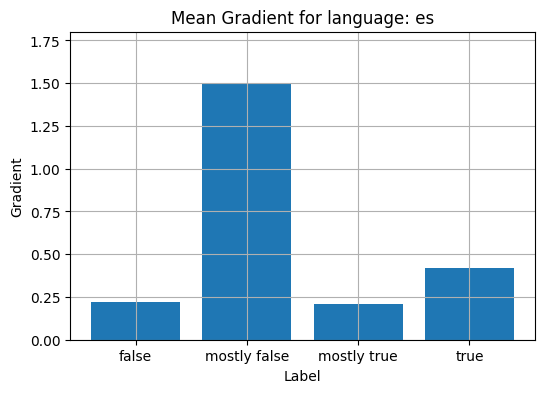

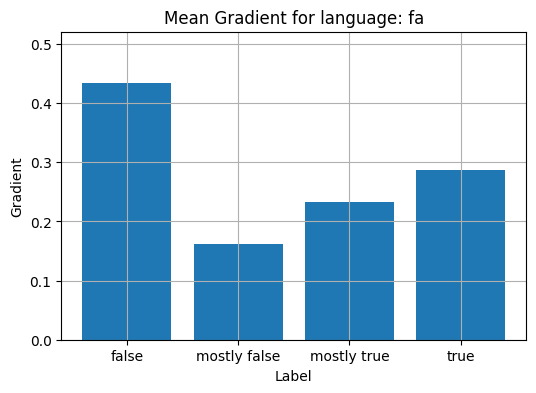

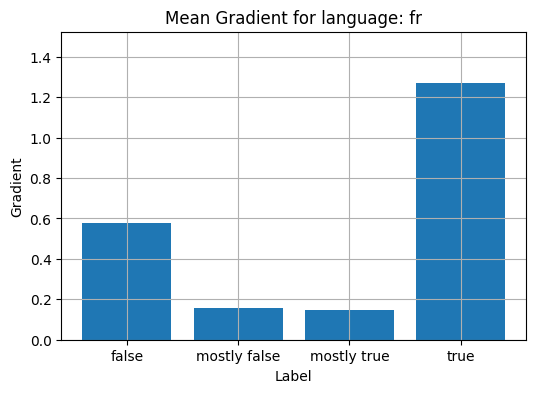

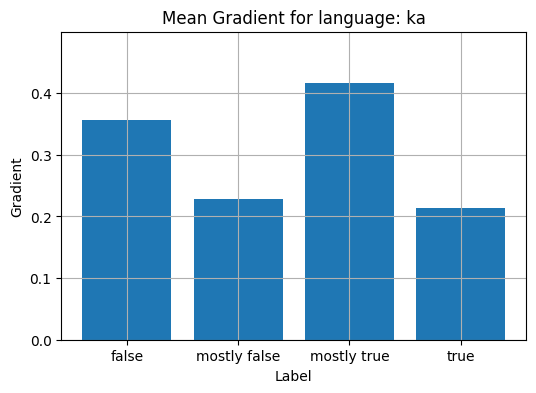

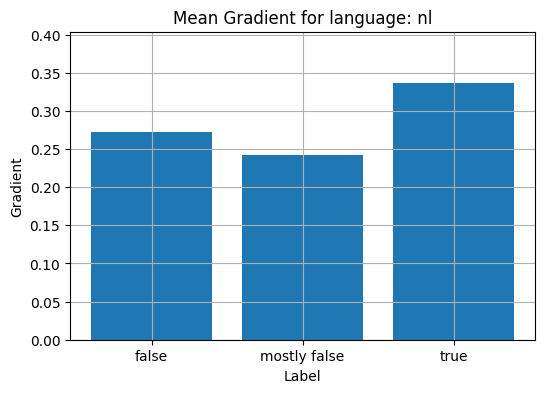

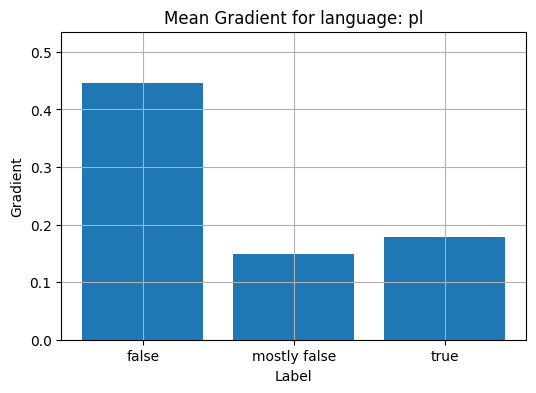

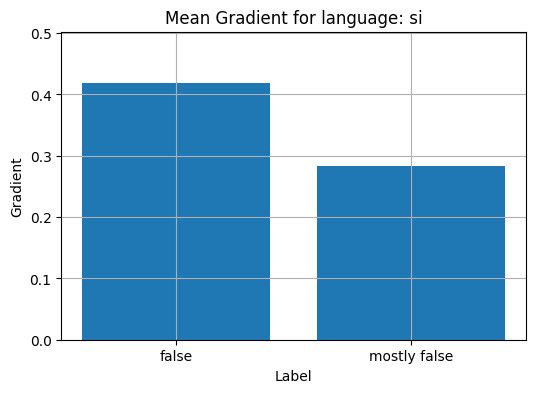

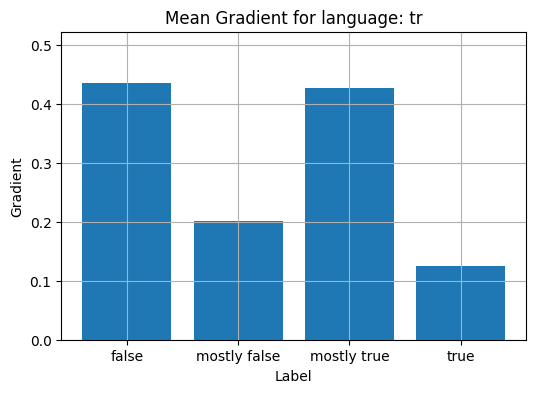

In [9]:
import numpy as np

languages = df_results["language"].unique()

for lang in languages:
    sub = df_results[df_results["language"] == lang]

    plt.figure(figsize=(6, 4))
    plt.bar(sub["label"], sub["avg_gradient"])
    plt.title(f"Mean Gradient for language: {lang}")
    plt.xlabel("Label")
    plt.ylabel("Gradient")
    plt.ylim(0, sub["avg_gradient"].max() * 1.2)
    plt.grid(True)
    plt.show()
